In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.table as table

#First, set up the catalog by loading in the table, and generating the concensus number of arms for each galaxy

In [44]:
vagc_t11 = table.Table.read('t11_vagc.fits')
vagc_t11 = vagc_t11[(0.02 <= vagc_t11['Z_1a']) * (vagc_t11['Z_1a'] <= 0.08)]
vagc_t11 = vagc_t11[vagc_t11['NEXPECT'] > 0.4]

N_GDVF = np.zeros(len(vagc_t11)).astype(int)
DVFs = np.column_stack((np.asarray(vagc_t11['t11_arms_number_a31_1_debiased']), 
                        np.asarray(vagc_t11['t11_arms_number_a32_2_debiased']),
                        np.asarray(vagc_t11['t11_arms_number_a33_3_debiased']), 
                        np.asarray(vagc_t11['t11_arms_number_a34_4_debiased']),
                        np.asarray(vagc_t11['t11_arms_number_a36_more_than_4_debiased']),
                        np.asarray(vagc_t11['t11_arms_number_a37_cant_tell_debiased'])))

N_GDVF = np.argmax(DVFs, axis = 1) + 1
N_GDVF[DVFs.sum(axis = 1) == 0] = 0

vagc_t11.add_column(table.Column(data = N_GDVF, name = 'N_arms'))

#Do the boxplots and violin plots

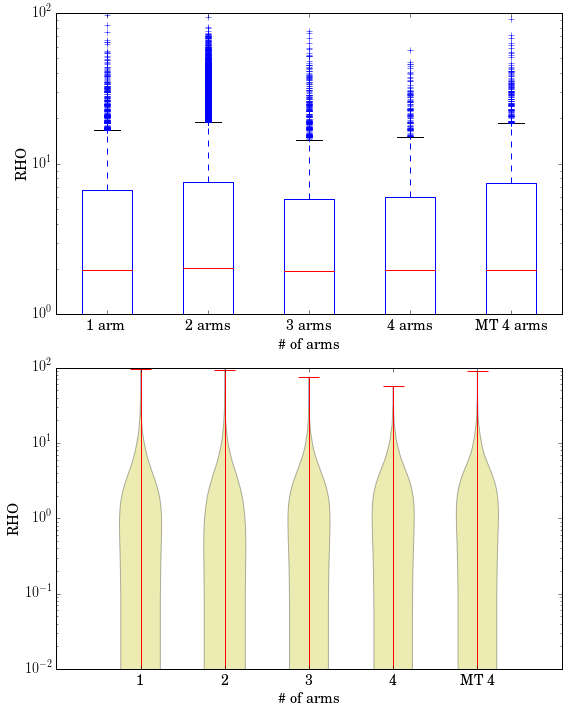

In [45]:
plt.figure(figsize = (8, 10))
ax1 = plt.subplot(211) #boxplots
ax2 = plt.subplot(212) #violinplots

ax1.boxplot(
    x = [vagc_t11['RHO'][vagc_t11['N_arms'] == 1],
        vagc_t11['RHO'][vagc_t11['N_arms'] == 2],
        vagc_t11['RHO'][vagc_t11['N_arms'] == 3],
        vagc_t11['RHO'][vagc_t11['N_arms'] == 4],
        vagc_t11['RHO'][vagc_t11['N_arms'] == 5]],
    labels = ['1 arm', '2 arms', '3 arms', '4 arms',
             'MT 4 arms']
)

#ax1.set_yscale('log')
ax1.set_xlabel('\# of arms')
ax1.set_ylabel('RHO')
ax1.set_yscale('log')

ax2.violinplot(
    [vagc_t11['RHO'][vagc_t11['N_arms'] == 1],
    vagc_t11['RHO'][vagc_t11['N_arms'] == 2],
    vagc_t11['RHO'][vagc_t11['N_arms'] == 3],
    vagc_t11['RHO'][vagc_t11['N_arms'] == 4],
    vagc_t11['RHO'][vagc_t11['N_arms'] == 5]],
    [1, 2, 3, 4, 5], points = 1000
)

ax2.set_xticks([1,2,3,4,5])
ax2.set_xticklabels(['1', '2', '3', '4', 'MT 4'])
ax2.set_ylabel('RHO')
ax2.set_xlabel('\# of arms')
ax2.set_yscale('log')

plt.tight_layout()

plt.show()

#Now do a KDE for the full sample in RHO-space

In [46]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity

In [47]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

In [48]:
rho_grid = np.linspace(0., 1.1*np.max(vagc_t11['RHO']), 100)
bandwidth_full = 1.06*np.std(vagc_t11['RHO'])*(len(vagc_t11['RHO']))**-0.2

n_full = len(vagc_t11['RHO'])
n_N1 = len(vagc_t11['RHO'][vagc_t11['N_arms'] == 1])
n_N2 = len(vagc_t11['RHO'][vagc_t11['N_arms'] == 2])
n_N3 = len(vagc_t11['RHO'][vagc_t11['N_arms'] == 3])
n_N4 = len(vagc_t11['RHO'][vagc_t11['N_arms'] == 4])
n_mt4 = len(vagc_t11['RHO'][vagc_t11['N_arms'] == 5])
n_ct = len(vagc_t11['RHO'][vagc_t11['N_arms'] == 6]) #zero

print zip(['1', '2', '3', '4', 'MT4'], [n_N1, n_N2, n_N3, n_N4, n_mt4])

bandwidth_1 = 1.06*np.std(vagc_t11['RHO'][vagc_t11['N_arms'] == 1])*n_N1**-0.2
bandwidth_2 = 1.06*np.std(vagc_t11['RHO'][vagc_t11['N_arms'] == 2])*n_N2**-0.2
bandwidth_3 = 1.06*np.std(vagc_t11['RHO'][vagc_t11['N_arms'] == 3])*n_N3**-0.2
bandwidth_4 = 1.06*np.std(vagc_t11['RHO'][vagc_t11['N_arms'] == 4])*n_N4**-0.2
bandwidth_mt4 = 1.06*np.std(vagc_t11['RHO'][vagc_t11['N_arms'] == 5])*n_mt4**-0.2
#bandwidth_ct = 1.06*np.std(vagc_t11['RHO'][vagc_t11['N_arms'] == 6])*n_ct**-0.2
print 'bandwidths:'
print zip(['1', '2', '3', '4', 'MT4'], [bandwidth_1, bandwidth_2, bandwidth_3, bandwidth_4, bandwidth_mt4])

kde_full = kde_sklearn(vagc_t11['RHO'], rho_grid, bandwidth=bandwidth_full)
kde_1 = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 1], rho_grid, bandwidth=bandwidth_1)
kde_2 = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 2], rho_grid, bandwidth=bandwidth_2)
kde_3 = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 3], rho_grid, bandwidth=bandwidth_3)
kde_4 = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 4], rho_grid, bandwidth=bandwidth_4)
kde_mt4 = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 5], rho_grid, bandwidth=bandwidth_mt4)
#kde_ct = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 6], rho_grid, bandwidth=bandwidth_ct)

[('1', 3793), ('2', 29995), ('3', 3225), ('4', 1300), ('MT4', 1959)]
bandwidths:
[('1', 1.6022364112562548), ('2', 1.1267770664898054), ('3', 1.5508656388870135), ('4', 1.8368556226404433), ('MT4', 2.0071806166058943)]


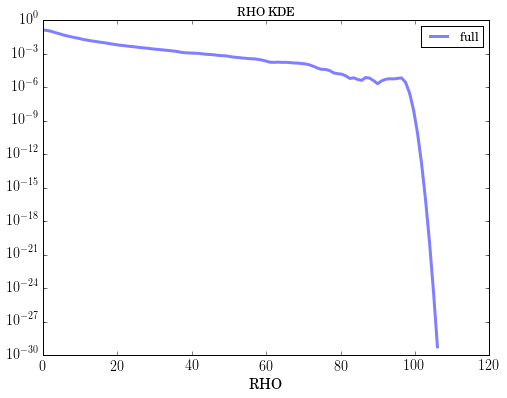

In [49]:
fig = plt.figure(figsize = (8, 6))
ax = plt.subplot(111)

ax.plot(rho_grid, kde_sklearn(vagc_t11['RHO'], rho_grid, bandwidth=bandwidth_full),
        label='full', linewidth=3, alpha=0.5)
ax.set_title('RHO KDE')
ax.set_xlabel('RHO')
ax.set_yscale('log')

#ax.set_yscale('log')
ax.legend(loc = 'best')

plt.show()

#Counting statistics wrt N

take KDE of all the different populations in RHO-space, separated by N.

Then transform to total counts. So, we end up with an estimate of the number of galaxies observed with a given arm multiplicity are present at a given environment density RHO.

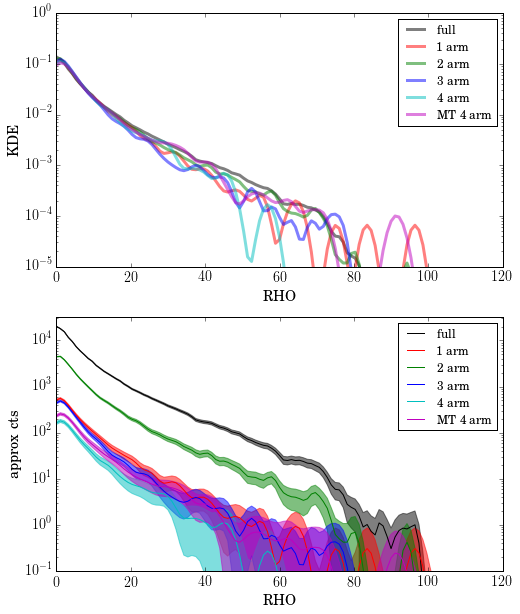

In [50]:
from scipy.integrate import trapz

fig = plt.figure(figsize = (8, 10))
ax1 = plt.subplot(211)

kde_integral = [trapz(kde, rho_grid) for kde in [kde_full, kde_1, kde_2, kde_3, kde_4, kde_mt4]]
N_n = [n_full, n_N1, n_N2, n_N3, n_N4, n_mt4]
mult = [N_n[i] * kde_integral[i] for i in range(len(N_n))]

ax1.plot(rho_grid, kde_full, label = 'full', linewidth=3, alpha = 0.5, c = 'k')
ax1.plot(rho_grid, kde_1, label='1 arm', linewidth=3, alpha=0.5, c = 'r')
ax1.plot(rho_grid, kde_2, label='2 arm', linewidth=3, alpha=0.5, c = 'g')
ax1.plot(rho_grid, kde_3, label='3 arm', linewidth=3, alpha=0.5, c = 'b')
ax1.plot(rho_grid, kde_4, label='4 arm', linewidth=3, alpha=0.5, c = 'c')
ax1.plot(rho_grid, kde_mt4, label='MT 4 arm', linewidth=3, alpha=0.5, c = 'm')

ax1.set_xlabel('RHO')
ax1.set_ylabel('KDE')

ax1.set_yscale('log')
ax1.set_ylim([10**-5., 1.])
ax1.legend(loc = 'best')

cts = [kde_full*N_n[0]/kde_integral[0], kde_1*N_n[1]/kde_integral[1], kde_2*N_n[2]/kde_integral[2], 
       kde_3*N_n[3]/kde_integral[3], kde_4*N_n[4]/kde_integral[4], kde_mt4*N_n[5]/kde_integral[5]]

ax2 = plt.subplot(212)
#ax2.plot(rho_grid, kde_full*mult[0], label = 'full', linewidth=3, alpha = 0.5, c = 'k')
ax2.fill_between(rho_grid, cts[0] - np.sqrt(cts[0]), cts[0] + np.sqrt(cts[0]), 
                 linewidth=1, alpha = 0.5, color = 'k')
ax2.fill_between(rho_grid, cts[1] - np.sqrt(cts[1]), cts[1] + np.sqrt(cts[1]), 
                 linewidth=1, alpha = 0.5, color = 'r')
ax2.fill_between(rho_grid, cts[2] - np.sqrt(cts[2]), cts[2] + np.sqrt(cts[2]), 
                 linewidth=1, alpha = 0.5, color = 'g')
ax2.fill_between(rho_grid, cts[3] - np.sqrt(cts[3]), cts[3] + np.sqrt(cts[3]), 
                 linewidth=1, alpha = 0.5, color = 'b')
ax2.fill_between(rho_grid, cts[4] - np.sqrt(cts[4]), cts[4] + np.sqrt(cts[4]), 
                 linewidth=1, alpha = 0.5, color = 'c')
ax2.fill_between(rho_grid, cts[5] - np.sqrt(cts[5]), cts[5] + np.sqrt(cts[5]), 
                 linewidth=1, alpha = 0.5, color = 'm')

ax2.plot(rho_grid, cts[0], linewidth = 1, color = 'k', label = 'full')
ax2.plot(rho_grid, cts[1], linewidth = 1, color = 'r', label = '1 arm')
ax2.plot(rho_grid, cts[2], linewidth = 1, color = 'g', label = '2 arm')
ax2.plot(rho_grid, cts[3], linewidth = 1, color = 'b', label = '3 arm')
ax2.plot(rho_grid, cts[4], linewidth = 1, color = 'c', label = '4 arm')
ax2.plot(rho_grid, cts[5], linewidth = 1, color = 'm', label = 'MT 4 arm')

ax2.set_yscale('log')
ax2.set_xlabel('RHO')
ax2.set_ylabel('approx cts')
ax2.set_ylim([10**-1., 10**4.5])

ax2.legend(loc = 'best')

plt.show()

#increase bandwidth

what happens if we increase the KDE bandwidth by a factor of 2?

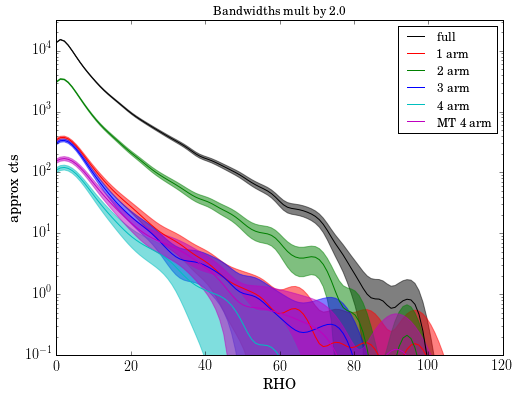

In [51]:
aug = 2.

kde_full_aug = kde_sklearn(vagc_t11['RHO'], rho_grid, bandwidth=bandwidth_full * aug)
kde_1_aug = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 1], rho_grid, bandwidth=bandwidth_1 * aug)
kde_2_aug = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 2], rho_grid, bandwidth=bandwidth_2 * aug)
kde_3_aug = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 3], rho_grid, bandwidth=bandwidth_3 * aug)
kde_4_aug = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 4], rho_grid, bandwidth=bandwidth_4 * aug)
kde_mt4_aug = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 5], rho_grid, bandwidth=bandwidth_mt4 * aug)

fig = plt.figure(figsize = (8, 6))

cts_aug = [kde_full_aug*N_n[0]/kde_integral[0], kde_1_aug*N_n[1]/kde_integral[1], kde_2_aug*N_n[2]/kde_integral[2], 
       kde_3_aug*N_n[3]/kde_integral[3], kde_4_aug*N_n[4]/kde_integral[4], kde_mt4_aug*N_n[5]/kde_integral[5]]

ax = plt.subplot(111)
#ax2.plot(rho_grid, kde_full*mult[0], label = 'full', linewidth=3, alpha = 0.5, c = 'k')
ax.fill_between(rho_grid, cts_aug[0] - np.sqrt(cts_aug[0]), cts_aug[0] + np.sqrt(cts_aug[0]), 
                 linewidth=1, alpha = 0.5, color = 'k')
ax.fill_between(rho_grid, cts_aug[1] - np.sqrt(cts_aug[1]), cts_aug[1] + np.sqrt(cts_aug[1]), 
                 linewidth=1, alpha = 0.5, color = 'r')
ax.fill_between(rho_grid, cts_aug[2] - np.sqrt(cts_aug[2]), cts_aug[2] + np.sqrt(cts_aug[2]), 
                 linewidth=1, alpha = 0.5, color = 'g')
ax.fill_between(rho_grid, cts_aug[3] - np.sqrt(cts_aug[3]), cts_aug[3] + np.sqrt(cts_aug[3]), 
                 linewidth=1, alpha = 0.5, color = 'b')
ax.fill_between(rho_grid, cts_aug[4] - np.sqrt(cts_aug[4]), cts_aug[4] + np.sqrt(cts_aug[4]), 
                 linewidth=1, alpha = 0.5, color = 'c')
ax.fill_between(rho_grid, cts_aug[5] - np.sqrt(cts_aug[5]), cts_aug[5] + np.sqrt(cts_aug[5]), 
                 linewidth=1, alpha = 0.5, color = 'm')

ax.plot(rho_grid, cts_aug[0], linewidth = 1, color = 'k', label = 'full')
ax.plot(rho_grid, cts_aug[1], linewidth = 1, color = 'r', label = '1 arm')
ax.plot(rho_grid, cts_aug[2], linewidth = 1, color = 'g', label = '2 arm')
ax.plot(rho_grid, cts_aug[3], linewidth = 1, color = 'b', label = '3 arm')
ax.plot(rho_grid, cts_aug[4], linewidth = 1, color = 'c', label = '4 arm')
ax.plot(rho_grid, cts_aug[5], linewidth = 1, color = 'm', label = 'MT 4 arm')

ax.set_yscale('log')
ax.set_xlabel('RHO')
ax.set_ylabel('approx cts')
ax.set_ylim([10**-1., 10**4.5])

ax.legend(loc = 'best')
ax.set_title('Bandwidths mult by {}'.format(aug))

plt.show()

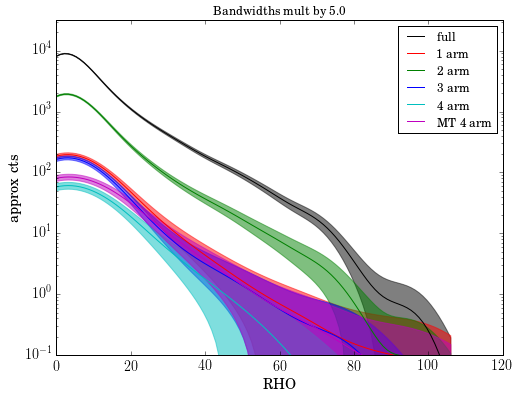

In [52]:
aug = 5.

kde_full_aug = kde_sklearn(vagc_t11['RHO'], rho_grid, bandwidth=bandwidth_full * aug)
kde_1_aug = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 1], rho_grid, bandwidth=bandwidth_1 * aug)
kde_2_aug = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 2], rho_grid, bandwidth=bandwidth_2 * aug)
kde_3_aug = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 3], rho_grid, bandwidth=bandwidth_3 * aug)
kde_4_aug = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 4], rho_grid, bandwidth=bandwidth_4 * aug)
kde_mt4_aug = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 5], rho_grid, bandwidth=bandwidth_mt4 * aug)

fig = plt.figure(figsize = (8, 6))

cts_aug = [kde_full_aug*N_n[0]/kde_integral[0], kde_1_aug*N_n[1]/kde_integral[1], kde_2_aug*N_n[2]/kde_integral[2], 
       kde_3_aug*N_n[3]/kde_integral[3], kde_4_aug*N_n[4]/kde_integral[4], kde_mt4_aug*N_n[5]/kde_integral[5]]

ax = plt.subplot(111)
#ax2.plot(rho_grid, kde_full*mult[0], label = 'full', linewidth=3, alpha = 0.5, c = 'k')
ax.fill_between(rho_grid, cts_aug[0] - np.sqrt(cts_aug[0]), cts_aug[0] + np.sqrt(cts_aug[0]), 
                 linewidth=1, alpha = 0.5, color = 'k')
ax.fill_between(rho_grid, cts_aug[1] - np.sqrt(cts_aug[1]), cts_aug[1] + np.sqrt(cts_aug[1]), 
                 linewidth=1, alpha = 0.5, color = 'r')
ax.fill_between(rho_grid, cts_aug[2] - np.sqrt(cts_aug[2]), cts_aug[2] + np.sqrt(cts_aug[2]), 
                 linewidth=1, alpha = 0.5, color = 'g')
ax.fill_between(rho_grid, cts_aug[3] - np.sqrt(cts_aug[3]), cts_aug[3] + np.sqrt(cts_aug[3]), 
                 linewidth=1, alpha = 0.5, color = 'b')
ax.fill_between(rho_grid, cts_aug[4] - np.sqrt(cts_aug[4]), cts_aug[4] + np.sqrt(cts_aug[4]), 
                 linewidth=1, alpha = 0.5, color = 'c')
ax.fill_between(rho_grid, cts_aug[5] - np.sqrt(cts_aug[5]), cts_aug[5] + np.sqrt(cts_aug[5]), 
                 linewidth=1, alpha = 0.5, color = 'm')

ax.plot(rho_grid, cts_aug[0], linewidth = 1, color = 'k', label = 'full')
ax.plot(rho_grid, cts_aug[1], linewidth = 1, color = 'r', label = '1 arm')
ax.plot(rho_grid, cts_aug[2], linewidth = 1, color = 'g', label = '2 arm')
ax.plot(rho_grid, cts_aug[3], linewidth = 1, color = 'b', label = '3 arm')
ax.plot(rho_grid, cts_aug[4], linewidth = 1, color = 'c', label = '4 arm')
ax.plot(rho_grid, cts_aug[5], linewidth = 1, color = 'm', label = 'MT 4 arm')

ax.set_yscale('log')
ax.set_xlabel('RHO')
ax.set_ylabel('approx cts')
ax.set_ylim([10**-1., 10**4.5])

ax.legend(loc = 'best')
ax.set_title('Bandwidths mult by {}'.format(aug))

plt.show()

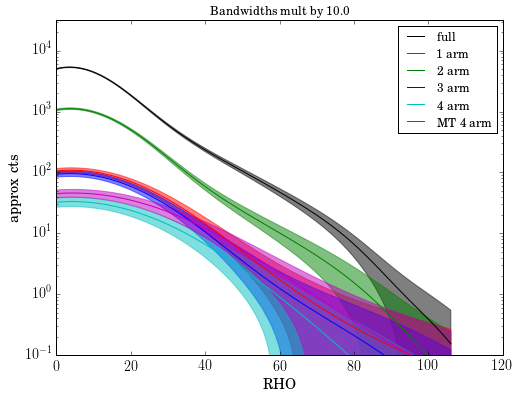

In [53]:
aug = 10.

kde_full_aug = kde_sklearn(vagc_t11['RHO'], rho_grid, bandwidth=bandwidth_full * aug)
kde_1_aug = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 1], rho_grid, bandwidth=bandwidth_1 * aug)
kde_2_aug = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 2], rho_grid, bandwidth=bandwidth_2 * aug)
kde_3_aug = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 3], rho_grid, bandwidth=bandwidth_3 * aug)
kde_4_aug = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 4], rho_grid, bandwidth=bandwidth_4 * aug)
kde_mt4_aug = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 5], rho_grid, bandwidth=bandwidth_mt4 * aug)

fig = plt.figure(figsize = (8, 6))

cts_aug = [kde_full_aug*N_n[0]/kde_integral[0], kde_1_aug*N_n[1]/kde_integral[1], kde_2_aug*N_n[2]/kde_integral[2], 
       kde_3_aug*N_n[3]/kde_integral[3], kde_4_aug*N_n[4]/kde_integral[4], kde_mt4_aug*N_n[5]/kde_integral[5]]

ax = plt.subplot(111)
#ax2.plot(rho_grid, kde_full*mult[0], label = 'full', linewidth=3, alpha = 0.5, c = 'k')
ax.fill_between(rho_grid, cts_aug[0] - np.sqrt(cts_aug[0]), cts_aug[0] + np.sqrt(cts_aug[0]), 
                 linewidth=1, alpha = 0.5, color = 'k')
ax.fill_between(rho_grid, cts_aug[1] - np.sqrt(cts_aug[1]), cts_aug[1] + np.sqrt(cts_aug[1]), 
                 linewidth=1, alpha = 0.5, color = 'r')
ax.fill_between(rho_grid, cts_aug[2] - np.sqrt(cts_aug[2]), cts_aug[2] + np.sqrt(cts_aug[2]), 
                 linewidth=1, alpha = 0.5, color = 'g')
ax.fill_between(rho_grid, cts_aug[3] - np.sqrt(cts_aug[3]), cts_aug[3] + np.sqrt(cts_aug[3]), 
                 linewidth=1, alpha = 0.5, color = 'b')
ax.fill_between(rho_grid, cts_aug[4] - np.sqrt(cts_aug[4]), cts_aug[4] + np.sqrt(cts_aug[4]), 
                 linewidth=1, alpha = 0.5, color = 'c')
ax.fill_between(rho_grid, cts_aug[5] - np.sqrt(cts_aug[5]), cts_aug[5] + np.sqrt(cts_aug[5]), 
                 linewidth=1, alpha = 0.5, color = 'm')

ax.plot(rho_grid, cts_aug[0], linewidth = 1, color = 'k', label = 'full')
ax.plot(rho_grid, cts_aug[1], linewidth = 1, color = 'r', label = '1 arm')
ax.plot(rho_grid, cts_aug[2], linewidth = 1, color = 'g', label = '2 arm')
ax.plot(rho_grid, cts_aug[3], linewidth = 1, color = 'b', label = '3 arm')
ax.plot(rho_grid, cts_aug[4], linewidth = 1, color = 'c', label = '4 arm')
ax.plot(rho_grid, cts_aug[5], linewidth = 1, color = 'm', label = 'MT 4 arm')

ax.set_yscale('log')
ax.set_xlabel('RHO')
ax.set_ylabel('approx cts')
ax.set_ylim([10**-1., 10**4.5])

ax.legend(loc = 'best')
ax.set_title('Bandwidths mult by {}'.format(aug))

plt.show()

#require clean IDs

trying now with galaxies with good sampling (i.e., that most people thought were actually spirals)

bandwidths:
[('1', 1.6991952401150099), ('2', 1.1324410517460564), ('3', 1.4155054817886739), ('4', 1.8319164455974266), ('MT4', 1.7108178253060062)]


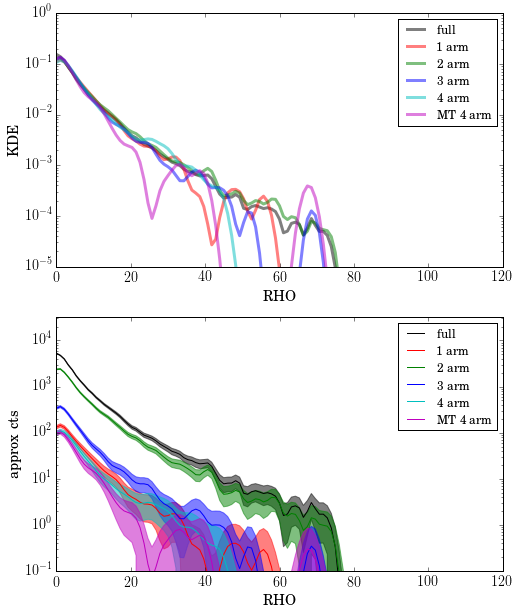

In [54]:
vagc_t11_clean = vagc_t11[vagc_t11['t11_arms_number_clean'] == 1]

bandwidth_full = 1.06*np.std(vagc_t11_clean['RHO'])*(len(vagc_t11_clean['RHO']))**-0.2

n_full = len(vagc_t11_clean['RHO'])
n_N1 = len(vagc_t11_clean['RHO'][vagc_t11_clean['N_arms'] == 1])
n_N2 = len(vagc_t11_clean['RHO'][vagc_t11_clean['N_arms'] == 2])
n_N3 = len(vagc_t11_clean['RHO'][vagc_t11_clean['N_arms'] == 3])
n_N4 = len(vagc_t11_clean['RHO'][vagc_t11_clean['N_arms'] == 4])
n_mt4 = len(vagc_t11_clean['RHO'][vagc_t11_clean['N_arms'] == 5])
n_ct = len(vagc_t11_clean['RHO'][vagc_t11_clean['N_arms'] == 6]) #zero

bandwidth_1 = 1.06*np.std(vagc_t11_clean['RHO'][vagc_t11_clean['N_arms'] == 1])*n_N1**-0.2
bandwidth_2 = 1.06*np.std(vagc_t11_clean['RHO'][vagc_t11_clean['N_arms'] == 2])*n_N2**-0.2
bandwidth_3 = 1.06*np.std(vagc_t11_clean['RHO'][vagc_t11_clean['N_arms'] == 3])*n_N3**-0.2
bandwidth_4 = 1.06*np.std(vagc_t11_clean['RHO'][vagc_t11_clean['N_arms'] == 4])*n_N4**-0.2
bandwidth_mt4 = 1.06*np.std(vagc_t11_clean['RHO'][vagc_t11_clean['N_arms'] == 5])*n_mt4**-0.2
#bandwidth_ct = 1.06*np.std(vagc_t11['RHO'][vagc_t11['N_arms'] == 6])*n_ct**-0.2
print 'bandwidths:'
print zip(['1', '2', '3', '4', 'MT4'], [bandwidth_1, bandwidth_2, bandwidth_3, bandwidth_4, bandwidth_mt4])

kde_full = kde_sklearn(vagc_t11_clean['RHO'], rho_grid, bandwidth=bandwidth_full)
kde_1 = kde_sklearn(vagc_t11_clean['RHO'][vagc_t11_clean['N_arms'] == 1], rho_grid, bandwidth=bandwidth_1)
kde_2 = kde_sklearn(vagc_t11_clean['RHO'][vagc_t11_clean['N_arms'] == 2], rho_grid, bandwidth=bandwidth_2)
kde_3 = kde_sklearn(vagc_t11_clean['RHO'][vagc_t11_clean['N_arms'] == 3], rho_grid, bandwidth=bandwidth_3)
kde_4 = kde_sklearn(vagc_t11_clean['RHO'][vagc_t11_clean['N_arms'] == 4], rho_grid, bandwidth=bandwidth_4)
kde_mt4 = kde_sklearn(vagc_t11_clean['RHO'][vagc_t11_clean['N_arms'] == 5], rho_grid, bandwidth=bandwidth_mt4)
#kde_ct = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 6], rho_grid, bandwidth=bandwidth_ct)

fig = plt.figure(figsize = (8, 10))
ax1 = plt.subplot(211)

kde_integral = [trapz(kde, rho_grid) for kde in [kde_full, kde_1, kde_2, kde_3, kde_4, kde_mt4]]
N_n = [n_full, n_N1, n_N2, n_N3, n_N4, n_mt4]
mult = [N_n[i] * kde_integral[i] for i in range(len(N_n))]

ax1.plot(rho_grid, kde_full, label = 'full', linewidth=3, alpha = 0.5, c = 'k')
ax1.plot(rho_grid, kde_1, label='1 arm', linewidth=3, alpha=0.5, c = 'r')
ax1.plot(rho_grid, kde_2, label='2 arm', linewidth=3, alpha=0.5, c = 'g')
ax1.plot(rho_grid, kde_3, label='3 arm', linewidth=3, alpha=0.5, c = 'b')
ax1.plot(rho_grid, kde_4, label='4 arm', linewidth=3, alpha=0.5, c = 'c')
ax1.plot(rho_grid, kde_mt4, label='MT 4 arm', linewidth=3, alpha=0.5, c = 'm')

ax1.set_xlabel('RHO')
ax1.set_ylabel('KDE')

ax1.set_yscale('log')
ax1.set_ylim([10**-5., 1.])
ax1.legend(loc = 'best')

cts = [kde_full*N_n[0]/kde_integral[0], kde_1*N_n[1]/kde_integral[1], kde_2*N_n[2]/kde_integral[2], 
       kde_3*N_n[3]/kde_integral[3], kde_4*N_n[4]/kde_integral[4], kde_mt4*N_n[5]/kde_integral[5]]

ax2 = plt.subplot(212)
#ax2.plot(rho_grid, kde_full*mult[0], label = 'full', linewidth=3, alpha = 0.5, c = 'k')
ax2.fill_between(rho_grid, cts[0] - np.sqrt(cts[0]), cts[0] + np.sqrt(cts[0]), 
                 linewidth=1, alpha = 0.5, color = 'k')
ax2.fill_between(rho_grid, cts[1] - np.sqrt(cts[1]), cts[1] + np.sqrt(cts[1]), 
                 linewidth=1, alpha = 0.5, color = 'r')
ax2.fill_between(rho_grid, cts[2] - np.sqrt(cts[2]), cts[2] + np.sqrt(cts[2]), 
                 linewidth=1, alpha = 0.5, color = 'g')
ax2.fill_between(rho_grid, cts[3] - np.sqrt(cts[3]), cts[3] + np.sqrt(cts[3]), 
                 linewidth=1, alpha = 0.5, color = 'b')
ax2.fill_between(rho_grid, cts[4] - np.sqrt(cts[4]), cts[4] + np.sqrt(cts[4]), 
                 linewidth=1, alpha = 0.5, color = 'c')
ax2.fill_between(rho_grid, cts[5] - np.sqrt(cts[5]), cts[5] + np.sqrt(cts[5]), 
                 linewidth=1, alpha = 0.5, color = 'm')

ax2.plot(rho_grid, cts[0], linewidth = 1, color = 'k', label = 'full')
ax2.plot(rho_grid, cts[1], linewidth = 1, color = 'r', label = '1 arm')
ax2.plot(rho_grid, cts[2], linewidth = 1, color = 'g', label = '2 arm')
ax2.plot(rho_grid, cts[3], linewidth = 1, color = 'b', label = '3 arm')
ax2.plot(rho_grid, cts[4], linewidth = 1, color = 'c', label = '4 arm')
ax2.plot(rho_grid, cts[5], linewidth = 1, color = 'm', label = 'MT 4 arm')

ax2.set_yscale('log')
ax2.set_xlabel('RHO')
ax2.set_ylabel('approx cts')
ax2.set_ylim([10**-1., 10**4.5])

ax2.legend(loc = 'best')

plt.show()

#require superclean IDs

bandwidths:
[('1', 2.0004577884663202), ('2', 1.19317953251623), ('3', 1.4481603364948603), ('4', 1.8632230832200853), ('MT4', 1.8131456074024745)]


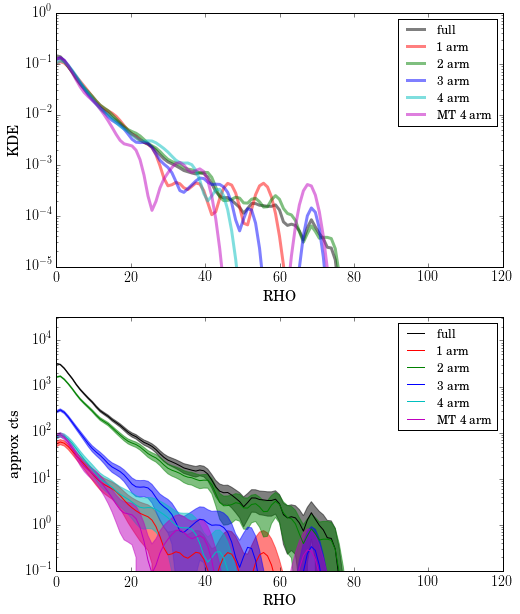

In [55]:
vagc_t11_superclean = vagc_t11[vagc_t11['t11_arms_number_superclean'] == 1]

bandwidth_full = 1.06*np.std(vagc_t11_superclean['RHO'])*(len(vagc_t11_superclean['RHO']))**-0.2

n_full = len(vagc_t11_superclean['RHO'])
n_N1 = len(vagc_t11_superclean['RHO'][vagc_t11_superclean['N_arms'] == 1])
n_N2 = len(vagc_t11_superclean['RHO'][vagc_t11_superclean['N_arms'] == 2])
n_N3 = len(vagc_t11_superclean['RHO'][vagc_t11_superclean['N_arms'] == 3])
n_N4 = len(vagc_t11_superclean['RHO'][vagc_t11_superclean['N_arms'] == 4])
n_mt4 = len(vagc_t11_superclean['RHO'][vagc_t11_superclean['N_arms'] == 5])
n_ct = len(vagc_t11_superclean['RHO'][vagc_t11_superclean['N_arms'] == 6]) #zero

bandwidth_1 = 1.06*np.std(vagc_t11_superclean['RHO'][vagc_t11_superclean['N_arms'] == 1])*n_N1**-0.2
bandwidth_2 = 1.06*np.std(vagc_t11_superclean['RHO'][vagc_t11_superclean['N_arms'] == 2])*n_N2**-0.2
bandwidth_3 = 1.06*np.std(vagc_t11_superclean['RHO'][vagc_t11_superclean['N_arms'] == 3])*n_N3**-0.2
bandwidth_4 = 1.06*np.std(vagc_t11_superclean['RHO'][vagc_t11_superclean['N_arms'] == 4])*n_N4**-0.2
bandwidth_mt4 = 1.06*np.std(vagc_t11_superclean['RHO'][vagc_t11_superclean['N_arms'] == 5])*n_mt4**-0.2
#bandwidth_ct = 1.06*np.std(vagc_t11['RHO'][vagc_t11['N_arms'] == 6])*n_ct**-0.2
print 'bandwidths:'
print zip(['1', '2', '3', '4', 'MT4'], [bandwidth_1, bandwidth_2, bandwidth_3, bandwidth_4, bandwidth_mt4])

kde_full = kde_sklearn(vagc_t11_superclean['RHO'], rho_grid, bandwidth=bandwidth_full)
kde_1 = kde_sklearn(vagc_t11_superclean['RHO'][vagc_t11_superclean['N_arms'] == 1], rho_grid, bandwidth=bandwidth_1)
kde_2 = kde_sklearn(vagc_t11_superclean['RHO'][vagc_t11_superclean['N_arms'] == 2], rho_grid, bandwidth=bandwidth_2)
kde_3 = kde_sklearn(vagc_t11_superclean['RHO'][vagc_t11_superclean['N_arms'] == 3], rho_grid, bandwidth=bandwidth_3)
kde_4 = kde_sklearn(vagc_t11_superclean['RHO'][vagc_t11_superclean['N_arms'] == 4], rho_grid, bandwidth=bandwidth_4)
kde_mt4 = kde_sklearn(vagc_t11_superclean['RHO'][vagc_t11_superclean['N_arms'] == 5], rho_grid, bandwidth=bandwidth_mt4)
#kde_ct = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 6], rho_grid, bandwidth=bandwidth_ct)

fig = plt.figure(figsize = (8, 10))
ax1 = plt.subplot(211)

kde_integral = [trapz(kde, rho_grid) for kde in [kde_full, kde_1, kde_2, kde_3, kde_4, kde_mt4]]
N_n = [n_full, n_N1, n_N2, n_N3, n_N4, n_mt4]
mult = [N_n[i] * kde_integral[i] for i in range(len(N_n))]

ax1.plot(rho_grid, kde_full, label = 'full', linewidth=3, alpha = 0.5, c = 'k')
ax1.plot(rho_grid, kde_1, label='1 arm', linewidth=3, alpha=0.5, c = 'r')
ax1.plot(rho_grid, kde_2, label='2 arm', linewidth=3, alpha=0.5, c = 'g')
ax1.plot(rho_grid, kde_3, label='3 arm', linewidth=3, alpha=0.5, c = 'b')
ax1.plot(rho_grid, kde_4, label='4 arm', linewidth=3, alpha=0.5, c = 'c')
ax1.plot(rho_grid, kde_mt4, label='MT 4 arm', linewidth=3, alpha=0.5, c = 'm')

ax1.set_xlabel('RHO')
ax1.set_ylabel('KDE')

ax1.set_yscale('log')
ax1.set_ylim([10**-5., 1.])
ax1.legend(loc = 'best')

cts = [kde_full*N_n[0]/kde_integral[0], kde_1*N_n[1]/kde_integral[1], kde_2*N_n[2]/kde_integral[2], 
       kde_3*N_n[3]/kde_integral[3], kde_4*N_n[4]/kde_integral[4], kde_mt4*N_n[5]/kde_integral[5]]

ax2 = plt.subplot(212)
#ax2.plot(rho_grid, kde_full*mult[0], label = 'full', linewidth=3, alpha = 0.5, c = 'k')
ax2.fill_between(rho_grid, cts[0] - np.sqrt(cts[0]), cts[0] + np.sqrt(cts[0]), 
                 linewidth=1, alpha = 0.5, color = 'k')
ax2.fill_between(rho_grid, cts[1] - np.sqrt(cts[1]), cts[1] + np.sqrt(cts[1]), 
                 linewidth=1, alpha = 0.5, color = 'r')
ax2.fill_between(rho_grid, cts[2] - np.sqrt(cts[2]), cts[2] + np.sqrt(cts[2]), 
                 linewidth=1, alpha = 0.5, color = 'g')
ax2.fill_between(rho_grid, cts[3] - np.sqrt(cts[3]), cts[3] + np.sqrt(cts[3]), 
                 linewidth=1, alpha = 0.5, color = 'b')
ax2.fill_between(rho_grid, cts[4] - np.sqrt(cts[4]), cts[4] + np.sqrt(cts[4]), 
                 linewidth=1, alpha = 0.5, color = 'c')
ax2.fill_between(rho_grid, cts[5] - np.sqrt(cts[5]), cts[5] + np.sqrt(cts[5]), 
                 linewidth=1, alpha = 0.5, color = 'm')

ax2.plot(rho_grid, cts[0], linewidth = 1, color = 'k', label = 'full')
ax2.plot(rho_grid, cts[1], linewidth = 1, color = 'r', label = '1 arm')
ax2.plot(rho_grid, cts[2], linewidth = 1, color = 'g', label = '2 arm')
ax2.plot(rho_grid, cts[3], linewidth = 1, color = 'b', label = '3 arm')
ax2.plot(rho_grid, cts[4], linewidth = 1, color = 'c', label = '4 arm')
ax2.plot(rho_grid, cts[5], linewidth = 1, color = 'm', label = 'MT 4 arm')

ax2.set_yscale('log')
ax2.set_xlabel('RHO')
ax2.set_ylabel('approx cts')
ax2.set_ylim([10**-1., 10**4.5])

ax2.legend(loc = 'best')

plt.show()